In [1]:
pip install legume-gme

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 1.5 MB/s eta 0:00:00


In [2]:
import legume

import numpy as np
import matplotlib.pyplot as  plt
import time

from legume.minimize import Minimize

%load_ext autoreload
%autoreload 2

In [3]:
central_radius = 0.3550
slab_height = 0.2
ring_width = 0.07
ring_number = 7
ring_period = 0.155

GaAs_permittivity = 12.25

Lx, Ly = 8, 8

In [4]:
def rings(dcenter, dperiod):


  lattice = legume.Lattice([Lx, 0], [0, Ly])
  phc = legume.PhotCryst(lattice)

  phc.add_layer(d = slab_height, eps_b = GaAs_permittivity)

  angles = np.linspace(0, 2*np.pi, 361)

  rings = []
  for j in range(ring_number):

    inner_radius = central_radius + dcenter + (ring_width + ring_period + dperiod) * j
    outer_radius = inner_radius + ring_width
    xs = []
    ys = []
    for angle in angles:
      xs.append(outer_radius * np.cos(angle))
      ys.append(outer_radius * np.sin(angle))
    for angleR in angles[::-1]:
      xs.append(inner_radius * np.cos(angleR))
      ys.append(inner_radius * np.sin(angleR))
    ring = legume.Poly(
        eps = 1.0,
        x_edges = xs,
        y_edges = ys
    )
    rings.append(ring)

  phc.add_shape(rings)

  return phc

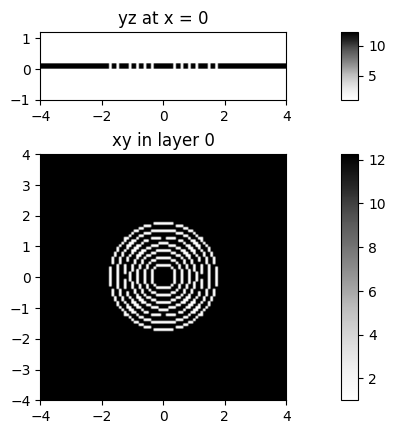

In [5]:
phc = rings(0.0, 0.0)
legume.viz.structure(phc, yz=True, figsize=4., cbar=True)

In [6]:
def get_kpoints(Lx, Ly, nkx, nky):

  # sample nkx and nky points in {kx, ky} space in a uniform grid
  # spacing between two reciprocal vectors is 2*pi/N

  kx = np.linspace(0, (nkx-1)/nkx*2*np.pi/Lx, nkx)
  ky = np.linspace(0, (nky-1)/nky*2*np.pi/Ly, nky)
  kxg, kyg = np.meshgrid(kx, ky)
  kxg = kxg.ravel()
  kyg = kyg.ravel()

  kpoints = np.vstack((kxg, kyg))

  return kpoints

In [60]:

def gme_cavity(dx, dy, gmax, truncate_g, options):

  bullseye = rings(dx, dy)

  options['compute_im'] = False

  gme = legume.GuidedModeExp(bullseye, gmax = gmax, truncate_g = truncate_g)

  kpoints_number = 2
  kpoints = get_kpoints(Lx, Ly, kpoints_number, kpoints_number)

  gme.run(kpoints = kpoints, **options)


  return gme

In [62]:
def Q_factor_calculation(gme, mode_index):

  (freq_im, _, _) = gme.compute_rad(0, [mode_index])

  Q = gme.freqs[0, mode_index]/2/freq_im[0]

  return Q

In [119]:
options = {
    'gmode_inds': [0],
    'verbose': True,
    'numeig': 100,
    'eig_sigma': 1.07,
    'gradients': 'approx'
}

gmax = 4

truncate_g = 'abs'
dx = 0.0
dy = 0.0

gme = gme_cavity(dx, dy, gmax, truncate_g, options)

Plane waves used in the expansion = 3209.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Steps in GuidedModeExp: 3209 plane waves and 1 guided modes ┃ Time (s) ┃                 % vs total T ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ Guided modes computation with gmode_compute='exact'         │ 1.150    │ │--------------------│    0% │
│ Inverse matrix of Fourier-space permittivity                │ 14.273   │ │--------------------│    4% │
│ Matrix diagionalization using the 'eigh' solver             │ 280.519  │ │████████████████----│   85% │
│ Creating GME matrix                                         │ 35.113   │ │██------------------│   11% │
├─────────────────────────────────────────────────────────────┼──────────┼──────────────────────────────┤
│ Total time for real part of frequencies for 4 k-points      │ 331.062  │ │████████████████████│  100% │
└─────────────────────────────────────────────────────────────┴──────────┴──────────────────────────────┘

Skipping imaginary part computation, use run_im() to run it, or compute_rad() to compute the radiative rates of 
selected eigenmodes

In [123]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('cavity_mode_profile_Ey.pdf') as pdf:
  for index in range(35, 45):

    # Print the computed quality factor
    print(f"index number {index}")
    Q_factor = Q_factor_calculation(gme, index)
    print("Cavity quality factor: %1.2f" %Q_factor)

    # We can also visualize the cavity and the mode profile of the fundamental mode

    plt.figure()
    ax = legume.viz.field(gme, 'e', 0, index, z=slab_height/2, component='y', val='abs', N1=300, N2=200)


    pdf.savefig(bbox_inches='tight')
    plt.close()


index number 35
Cavity quality factor: 28910.10
index number 36
Cavity quality factor: 14671.24
index number 37
Cavity quality factor: 1244.06
index number 38
Cavity quality factor: 1244.06
index number 39
Cavity quality factor: 614.41
index number 40
Cavity quality factor: 614.41
index number 41
Cavity quality factor: 10746.41
index number 42
Cavity quality factor: 80192.93
index number 43
Cavity quality factor: 22801.15
index number 44
Cavity quality factor: 3926.23


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [124]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages('cavity_mode_profile_Ex.pdf') as pdf:
  for index in range(35, 45):

    # Print the computed quality factor
    print(f"index number {index}")
    Q_factor = Q_factor_calculation(gme, index)
    print("Cavity quality factor: %1.2f" %Q_factor)

    # We can also visualize the cavity and the mode profile of the fundamental mode

    plt.figure()
    ax = legume.viz.field(gme, 'e', 0, index, z=slab_height/2, component='x', val='abs', N1=300, N2=200)


    pdf.savefig(bbox_inches='tight')
    plt.close()


index number 35
Cavity quality factor: 28910.10
index number 36
Cavity quality factor: 14671.24
index number 37
Cavity quality factor: 1244.06
index number 38
Cavity quality factor: 1244.06
index number 39
Cavity quality factor: 614.41
index number 40
Cavity quality factor: 614.41
index number 41
Cavity quality factor: 10746.41
index number 42
Cavity quality factor: 80192.93
index number 43
Cavity quality factor: 22801.15
index number 44
Cavity quality factor: 3926.23


<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>